In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import glob
import pandas as pd

In [2]:
files = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/storm_reports/StormEvents_details-ftp_v1.0_d*.csv'))

In [3]:
# Import a single ERA5 file so that we have a lat/lon grid for reference
era5_data = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')

In [4]:
# Subset a CONUS box
era5_data_conus = era5_data['CAPE'].sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [24]:
# Subset the US east of the Rockies
era5_data_east = era5_data_conus.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [ ]:
# Subset an eastern US region
cape_conus_mam_anoms_east = cape_conus_mam_detrend.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

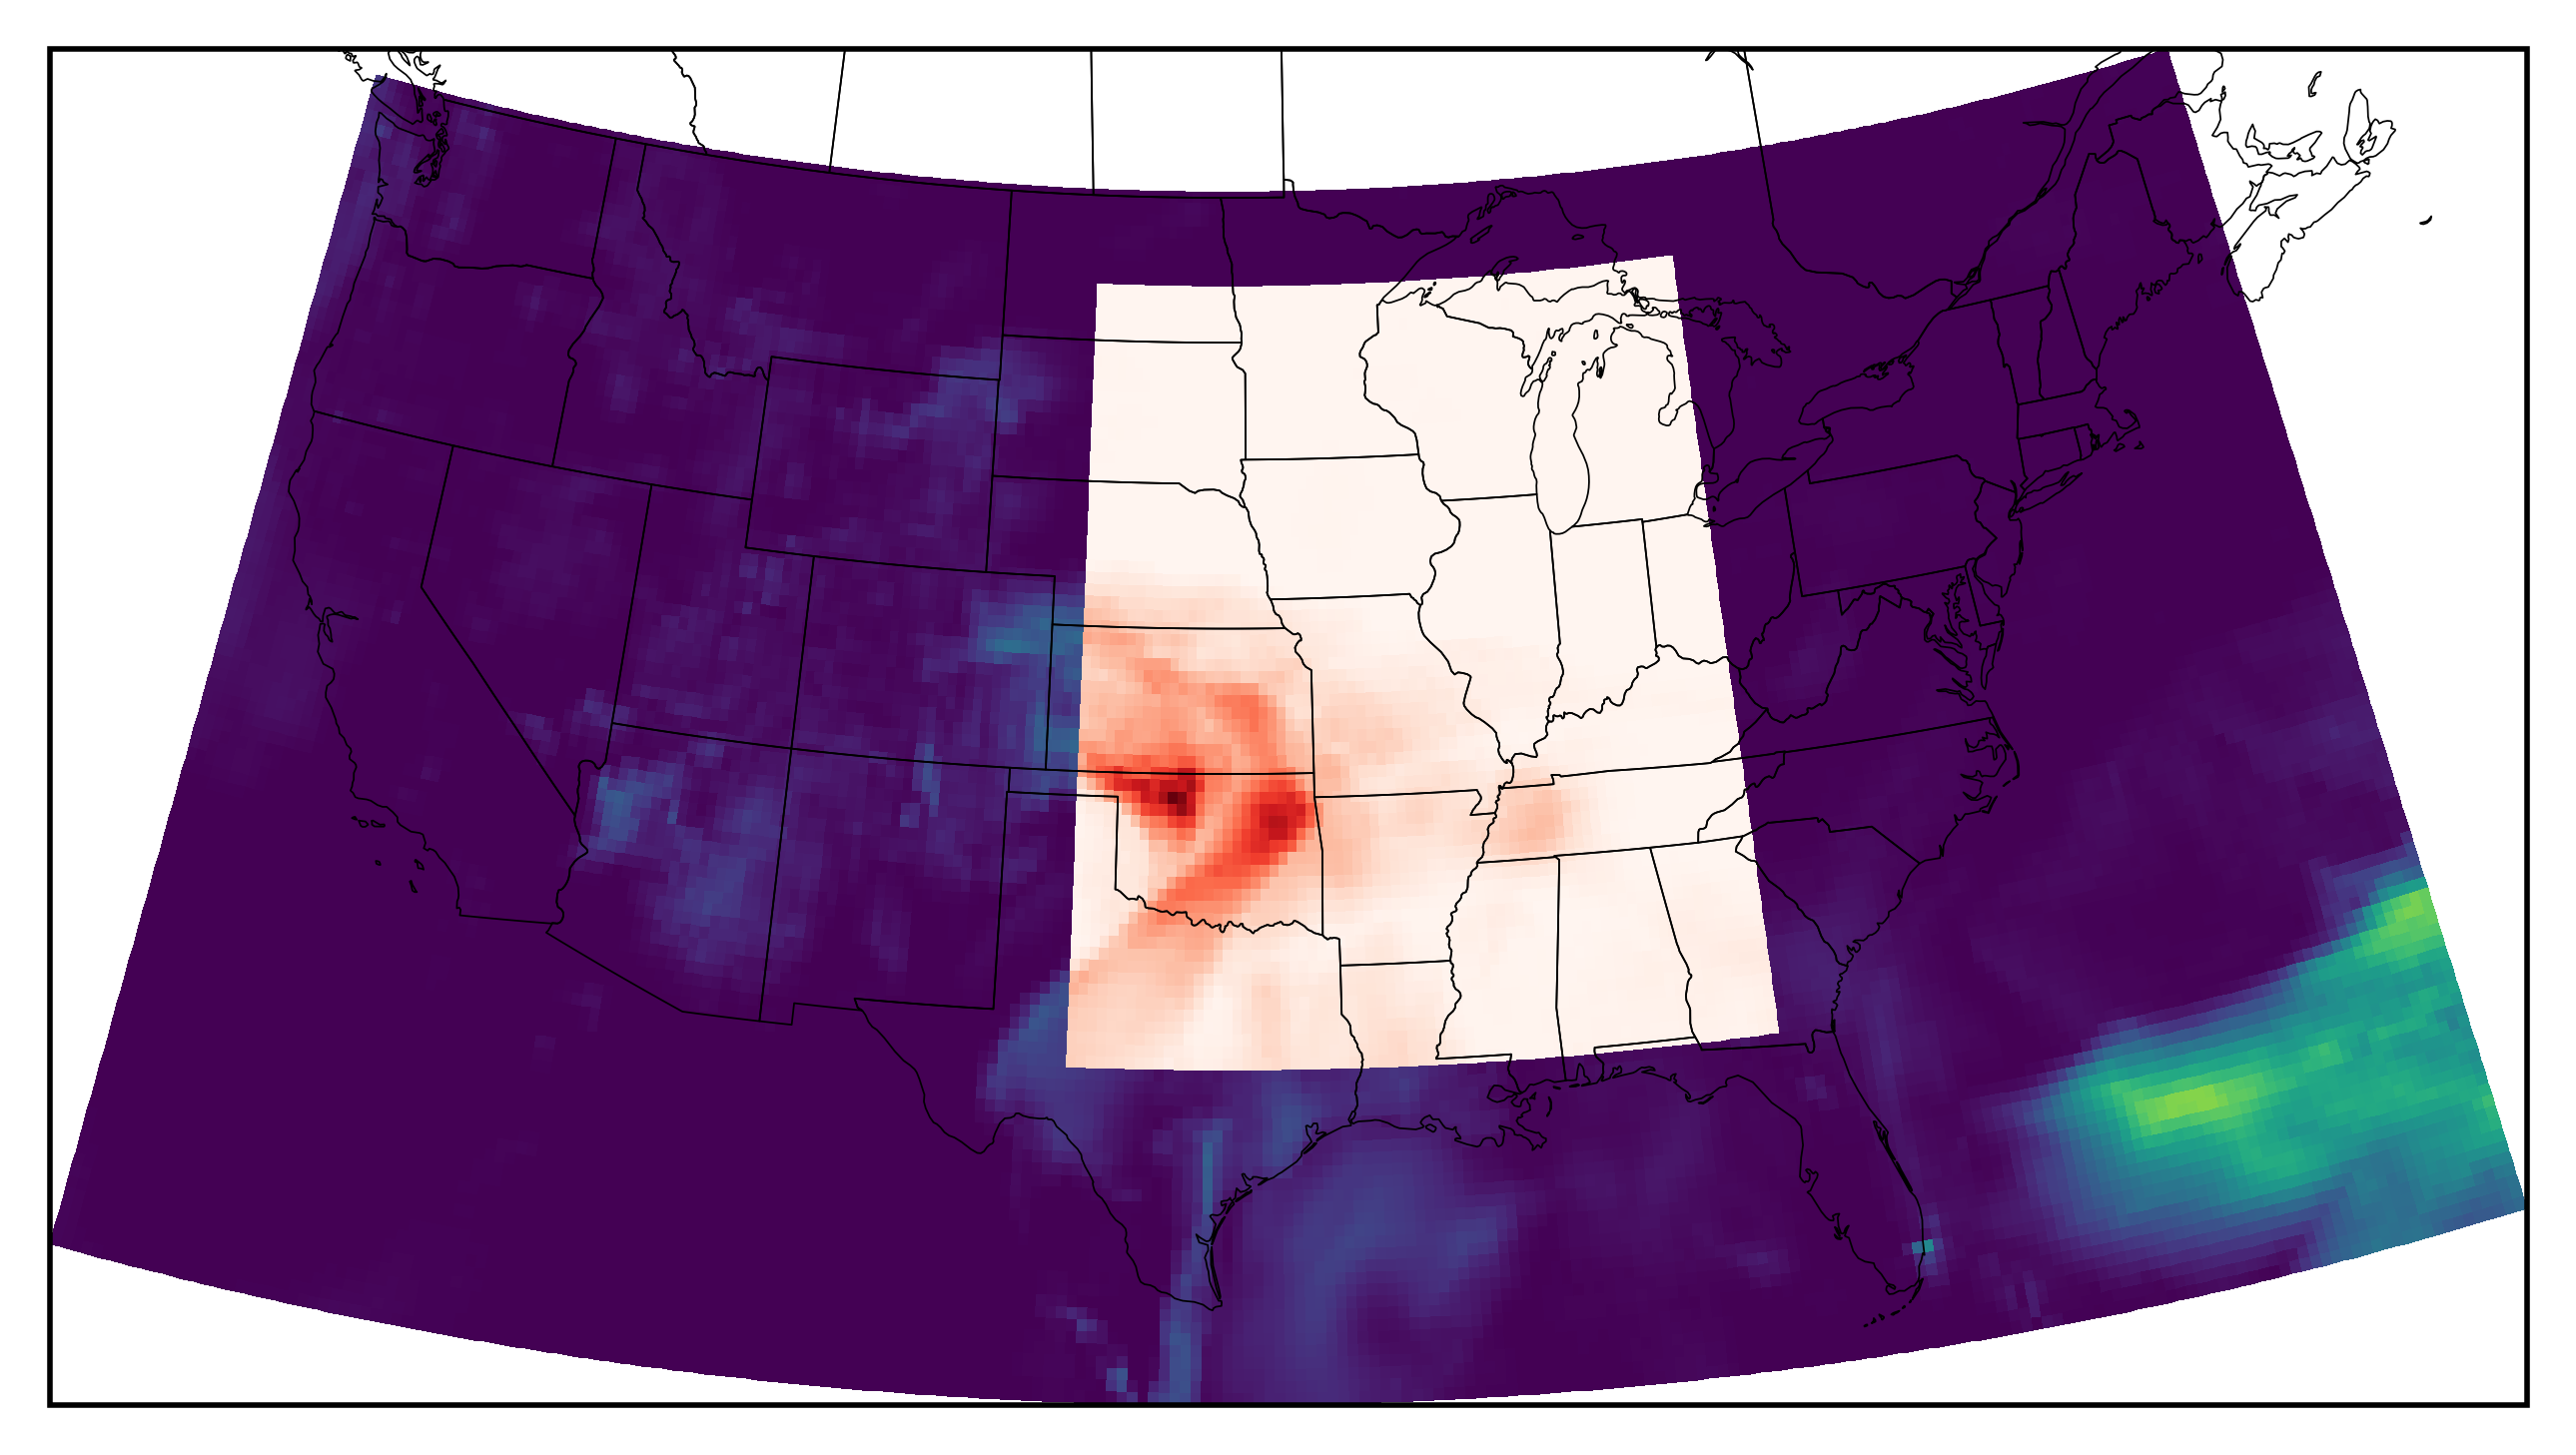

In [25]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax.add_feature(ct.feature.STATES, lw=0.25)

ax.pcolormesh(era5_data_conus['longitude'], era5_data_conus['latitude'], era5_data_conus[0], transform=ccrs.PlateCarree())

ax.pcolormesh(era5_data_east['longitude'], era5_data_east['latitude'], era5_data_east[0], transform=ccrs.PlateCarree(), cmap='Reds')

In [5]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [6]:
# Standardize nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [7]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1980-2024
pdo_1980_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))
nino_34_1980_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1980, 2025, 1)))

# only MAM
pdo_1980_2024_mam = pdo_1980_2024.sel(time=pdo_1980_2024.time.dt.month.isin([3, 4, 5]))
nino_34_1980_2024_mam = nino_34_1980_2024.sel(time=nino_34_1980_2024.time.dt.month.isin([3, 4, 5]))

In [8]:
# Read and concatenate in order
storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

/tmp/ipykernel_146573/3445745825.py:2: DtypeWarning: Columns (26,48) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_146573/3445745825.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_146573/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_146573/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_146573/3445745825.py:2: DtypeWarning: Columns (29,34,35,37) have mixed type

In [9]:
storm_reports['BEGIN_YEARMONTH'] = pd.to_datetime(storm_reports['BEGIN_YEARMONTH'], format='%Y%m')
storm_reports['END_YEARMONTH'] = pd.to_datetime(storm_reports['END_YEARMONTH'], format='%Y%m')

In [10]:
# Extract the month
storm_reports["MONTH"] = storm_reports["BEGIN_YEARMONTH"].dt.month

In [11]:
# Specify different storm types
tornados = storm_reports[storm_reports['EVENT_TYPE'].isin(['Tornado'])]
hail = storm_reports[storm_reports['EVENT_TYPE'].isin(['Hail'])]
tstorm_wind = storm_reports[storm_reports['EVENT_TYPE'].isin(['Thunderstorm Wind'])]

In [12]:
# Subset storm reports by time periods
tornados_mam = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tornados_mar = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3])]
tornados_apr = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([4])]
tornados_may = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([5])]

hail_mam = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
hail_mar = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3])]
hail_apr = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([4])]
hail_may = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([5])]

tstorm_wind_mam = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tstorm_wind_mar = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3])]
tstorm_wind_apr = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([4])]
tstorm_wind_may = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([5])]

In [13]:
# Want to mess around with grid size a little bit to see if we can get a more coherent signal
lat_edges = np.append(era5_data_conus['latitude'].values-0.25, 23.5)
lon_edges = np.append(era5_data_conus['longitude'].values-0.25, 294)

lat_edges_0_5deg = lat_edges[::2]
lon_edges_0_5deg = lon_edges[::2]

In [29]:
lat_edges_east = np.append(era5_data_east['latitude'][0], era5_data_east['latitude'][-1])
lon_edges_east = np.append(era5_data_east['longitude'][0], era5_data_east['longitude'][-1])

In [47]:
# I want storm report counts within the grid that I just made
tornado_counts_mam_separated_east = np.zeros((135))
tstorm_wind_counts_mam_separated_east = np.zeros((135))
hail_counts_mam_separated_east = np.zeros((135))
for i in range(45):
    tornado_yr_mar_east = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_apr_east = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_may_east = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tstorm_wind_yr_mar_east = tstorm_wind_mar.loc[tstorm_wind_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_apr_east = tstorm_wind_apr.loc[tstorm_wind_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_may_east = tstorm_wind_may.loc[tstorm_wind_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    hail_yr_mar_east = hail_mar.loc[hail_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_apr_east = hail_apr.loc[hail_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_may_east = hail_may.loc[hail_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tornado_counts_mam_separated_east[i*3] = pdo_functions.count_in_grid(tornado_yr_mar_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
    tornado_counts_mam_separated_east[i*3+1] = pdo_functions.count_in_grid(tornado_yr_apr_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
    tornado_counts_mam_separated_east[i*3+2] = pdo_functions.count_in_grid(tornado_yr_may_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]

    tstorm_wind_counts_mam_separated_east[i*3] = pdo_functions.count_in_grid(tstorm_wind_yr_mar_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_mar_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
    tstorm_wind_counts_mam_separated_east[i*3+1] = pdo_functions.count_in_grid(tstorm_wind_yr_apr_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_apr_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
    tstorm_wind_counts_mam_separated_east[i*3+2] = pdo_functions.count_in_grid(tstorm_wind_yr_may_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_may_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]

    hail_counts_mam_separated_east[i*3] = pdo_functions.count_in_grid(hail_yr_mar_east['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_mar_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
    hail_counts_mam_separated_east[i*3+1] = pdo_functions.count_in_grid(hail_yr_apr_east['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_apr_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
    hail_counts_mam_separated_east[i*3+2] = pdo_functions.count_in_grid(hail_yr_may_east['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_may_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]

/tmp/ipykernel_146573/3844729428.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tornado_counts_mam_separated_east[i*3] = pdo_functions.count_in_grid(tornado_yr_mar_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
/tmp/ipykernel_146573/3844729428.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tornado_counts_mam_separated_east[i*3+1] = pdo_functions.count_in_grid(tornado_yr_apr_east['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr_east['BEGIN_LON']), np.sort(lat_edges_east), lon_edges_east)[0]
/tmp/ipykernel_146573/3844729428.py:20: De

In [14]:
tornado_counts_mam_separated = np.zeros((135, 50, 118))
for i in range(45):
    tornado_yr_mar = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_apr = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_may = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tornado_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tornado_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tornado_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tornado_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tornado_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tornado_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [15]:
hail_counts_mam_separated = np.zeros((135, 50, 118))

for i in range(45):
    hail_yr_mar = hail_mar.loc[hail_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_apr = hail_apr.loc[hail_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_may = hail_may.loc[hail_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    hail_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(hail_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    hail_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(hail_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    hail_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(hail_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [16]:
tstorm_wind_counts_mam_separated = np.zeros((135, 50, 118))

for i in range(45):
    tstorm_wind_yr_mar = tstorm_wind_mar.loc[tstorm_wind_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_apr = tstorm_wind_apr.loc[tstorm_wind_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_may = tstorm_wind_may.loc[tstorm_wind_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tstorm_wind_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tstorm_wind_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tstorm_wind_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tstorm_wind_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tstorm_wind_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tstorm_wind_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [64]:
# Fill zeros with nans
tornado_counts_mam_separated_east[tornado_counts_mam_separated_east == 0] = np.nan
tstorm_wind_counts_mam_separated_east[tstorm_wind_counts_mam_separated_east == 0] = np.nan
hail_counts_mam_separated_east[hail_counts_mam_separated_east == 0] = np.nan

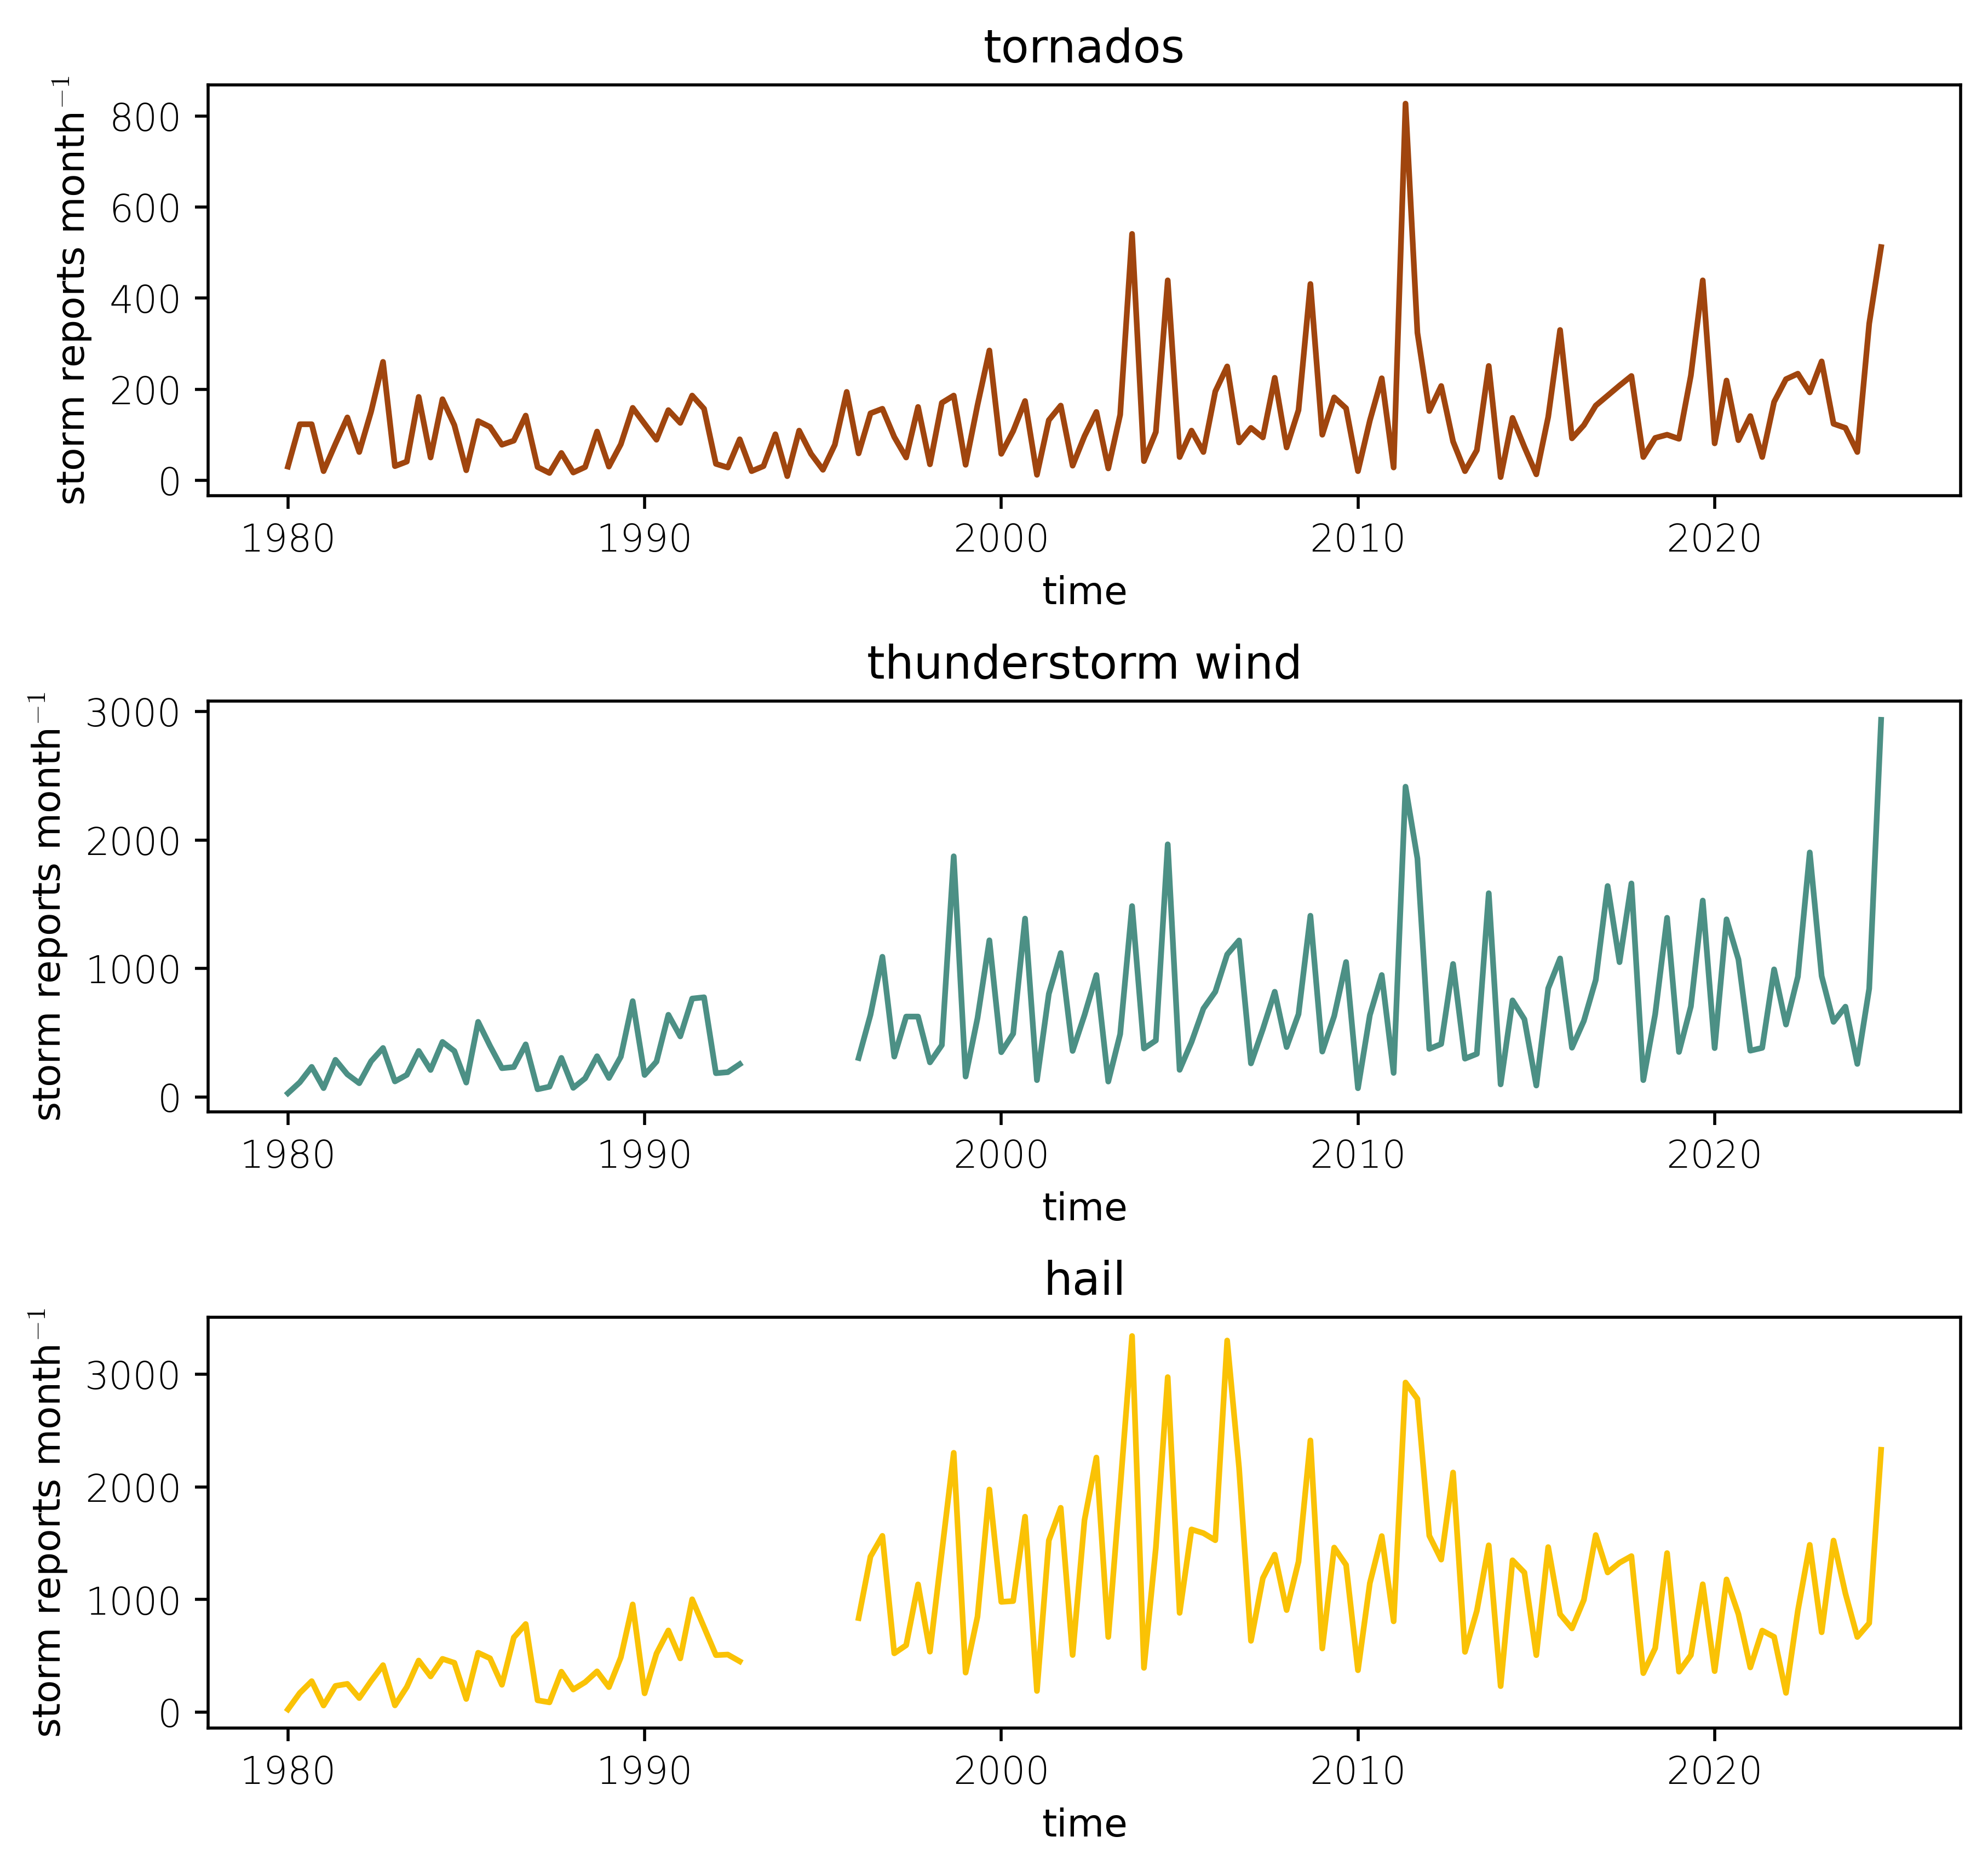

In [74]:
fig, ax = plt.subplots(3, 1)

time_arr = np.arange(1980, 2025, (1/3))

for i in range(3):
    ax[i].set_ylabel('storm reports month$^{-1}$')
    ax[i].set_xlabel('time')

ax[0].plot(time_arr, tornado_counts_mam_separated_east, color='xkcd:burnt umber')
ax[1].plot(time_arr, tstorm_wind_counts_mam_separated_east, color='xkcd:dusty teal')
ax[2].plot(time_arr, hail_counts_mam_separated_east, color='xkcd:goldenrod')

ax[0].set_title('tornados')
ax[1].set_title('thunderstorm wind')
ax[2].set_title('hail')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.5, 
                    wspace=0.05, 
                    hspace=0.5)